In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the wholesale customer dataset
df = pd.read_csv('/content/Wholesale customers data.csv')

In [3]:
# Display basic information about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None


In [4]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
df.isnull().sum()

,0
Channel,0
Region,0
Fresh,0
Milk,0
Grocery,0
Frozen,0
Detergents_Paper,0
Delicassen,0


In [6]:
features_for_clustering = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
X = df[features_for_clustering]

In [8]:
# Standardize the features (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame with scaled features
X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering)
X_scaled_df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339
1,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151
2,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293
3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411
4,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347


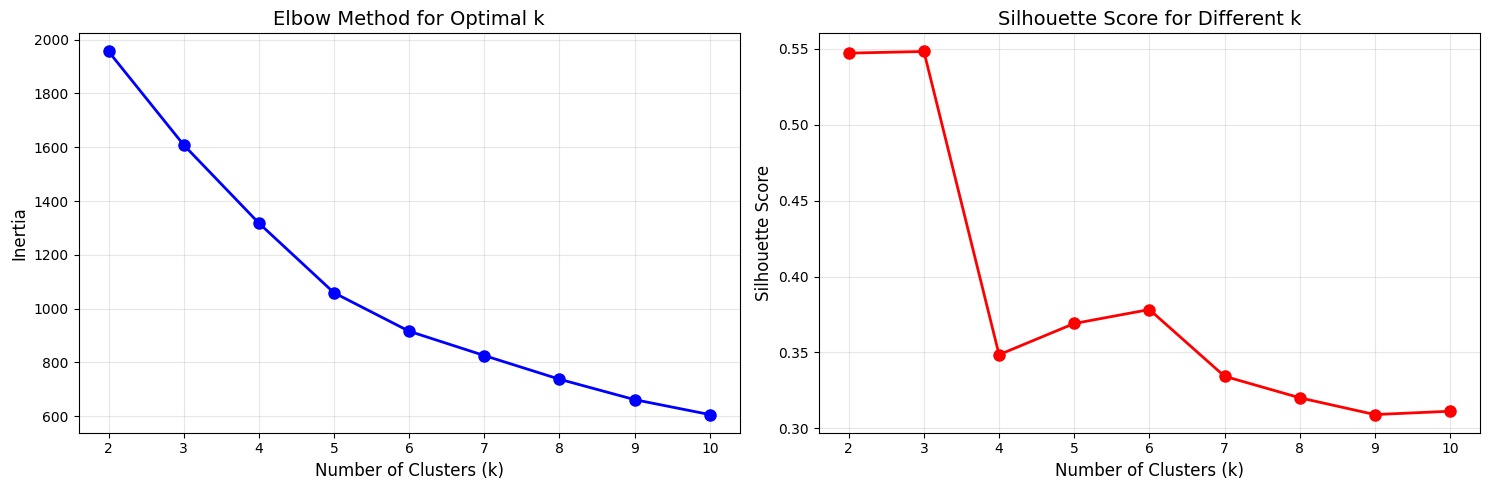

In [10]:
#K-Means Clustering
# Elbow Method for K-Means
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow Curve and Silhouette Score
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.set_title('Elbow Method for Optimal k', fontsize=14)
ax1.grid(True, alpha=0.3)

# Silhouette Score
ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score for Different k', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Find optimal k based on silhouette score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on Silhouette Score: {optimal_k}")

# Create K-Means Model with Optimal Clusters

# Create K-Means model with optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_optimal.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df['KMeans_Cluster'] = kmeans_labels

# Display cluster statistics
print(f"K-Means Clustering with {optimal_k} clusters")
print("\nCluster Sizes:")
print(df['KMeans_Cluster'].value_counts().sort_index())

Optimal number of clusters based on Silhouette Score: 3
K-Means Clustering with 3 clusters

Cluster Sizes:
KMeans_Cluster
0     45
1    393
2      2
Name: count, dtype: int64


In [14]:
cluster_centers = scaler.inverse_transform(kmeans_optimal.cluster_centers_)
cluster_centers_df = pd.DataFrame(cluster_centers, columns=features_for_clustering)
cluster_centers_df['Cluster'] = range(optimal_k)
cluster_centers_df

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,10440.933333,19386.422222,28656.088889,2190.244444,13327.800000,2374.200000,0
1,12062.913486,4115.099237,5534.966921,2940.676845,1696.170483,1299.114504,1
2,34782.000000,30367.000000,16898.000000,48701.500000,755.500000,26776.000000,2


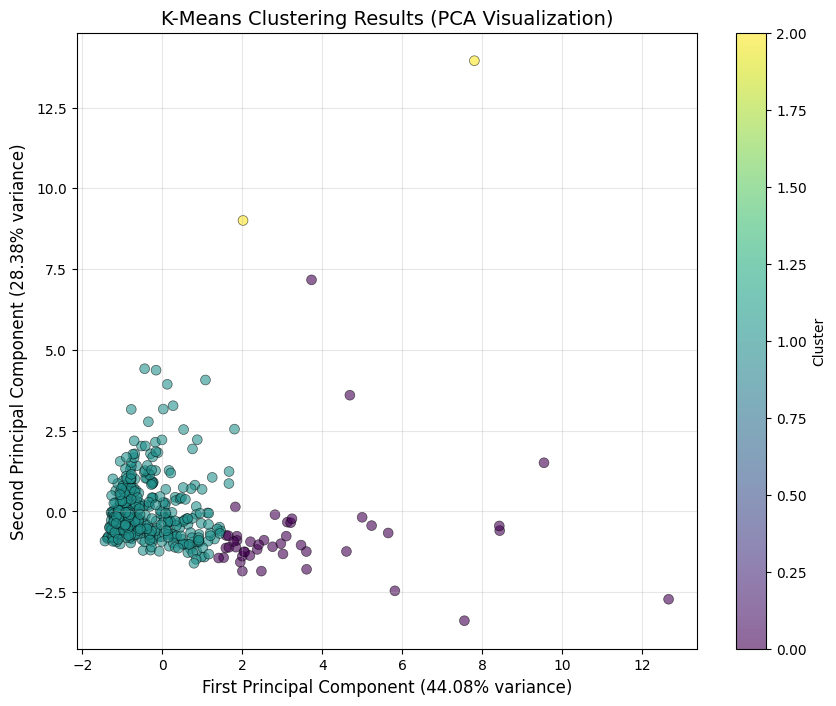

In [15]:
# Visualize K-Means clusters using PCA (for 2D visualization)
pca_viz = PCA(n_components=2, random_state=42)
X_pca_viz = pca_viz.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_viz[:, 0], X_pca_viz[:, 1],
                     c=kmeans_labels, cmap='viridis',
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'First Principal Component ({pca_viz.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'Second Principal Component ({pca_viz.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('K-Means Clustering Results (PCA Visualization)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

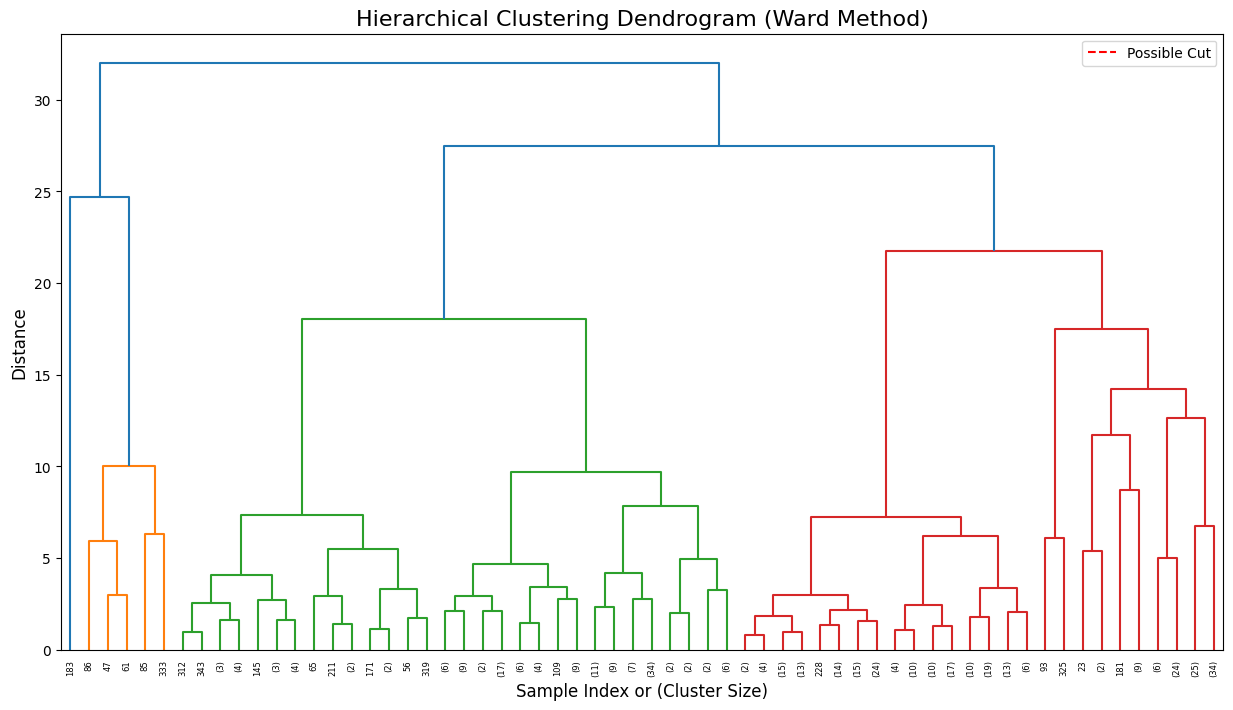

In [16]:
#Hierarchical Clustering

# Create dendrogram to find optimal number of clusters
plt.figure(figsize=(15, 8))
dendrogram_data = dendrogram(linkage(X_scaled, method='ward'),
                            truncate_mode='level',
                            p=6)
plt.title('Hierarchical Clustering Dendrogram (Ward Method)', fontsize=16)
plt.xlabel('Sample Index or (Cluster Size)', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.axhline(y=50, color='r', linestyle='--', label='Possible Cut')
plt.legend()
plt.show()

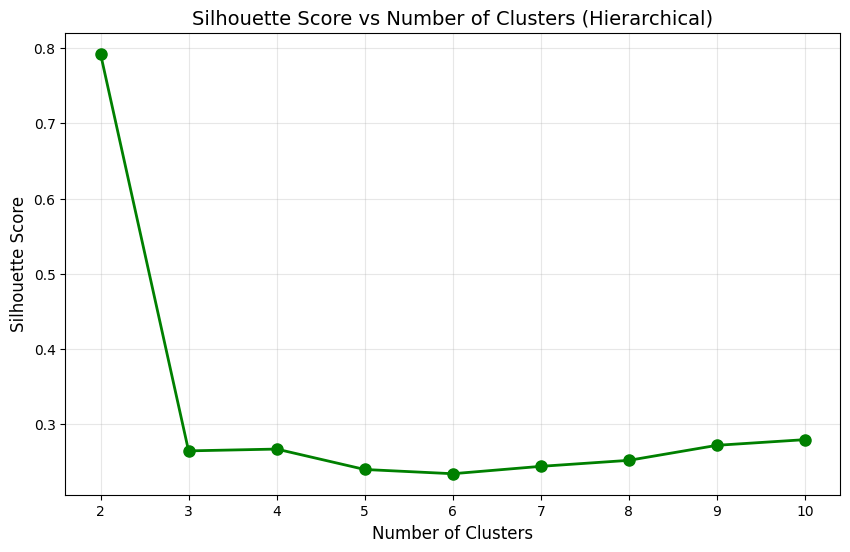

In [17]:
#Finding Optimal Number of Clusters

# Test different numbers of clusters for Hierarchical Clustering
silhouette_scores_hc = []
n_clusters_range = range(2, 11)

for n_clusters in n_clusters_range:
    hc = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    hc_labels = hc.fit_predict(X_scaled)
    silhouette_scores_hc.append(silhouette_score(X_scaled, hc_labels))

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, silhouette_scores_hc, 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score vs Number of Clusters (Hierarchical)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

In [18]:
optimal_hc_clusters = n_clusters_range[np.argmax(silhouette_scores_hc)]
print(f"Optimal number of clusters for Hierarchical Clustering: {optimal_hc_clusters}")

Optimal number of clusters for Hierarchical Clustering: 2


In [19]:
# Create Hierarchical Clustering model with optimal clusters
hc_optimal = AgglomerativeClustering(n_clusters=optimal_hc_clusters, linkage='ward')
hc_labels = hc_optimal.fit_predict(X_scaled)

# Add cluster labels to dataframe
df['HC_Cluster'] = hc_labels

# Display cluster statistics
print(f"Hierarchical Clustering with {optimal_hc_clusters} clusters")
print("\nCluster Sizes:")
print(df['HC_Cluster'].value_counts().sort_index())

Hierarchical Clustering with 2 clusters

Cluster Sizes:
HC_Cluster
0    434
1      6
Name: count, dtype: int64


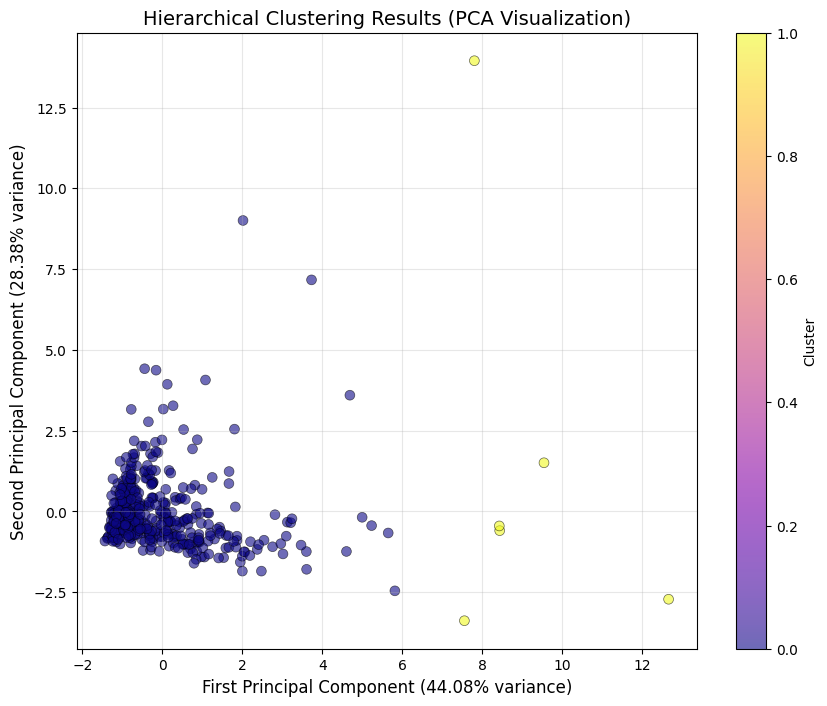

In [20]:
# Visualize Hierarchical clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_viz[:, 0], X_pca_viz[:, 1],
                     c=hc_labels, cmap='plasma',
                     s=50, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'First Principal Component ({pca_viz.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'Second Principal Component ({pca_viz.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('Hierarchical Clustering Results (PCA Visualization)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

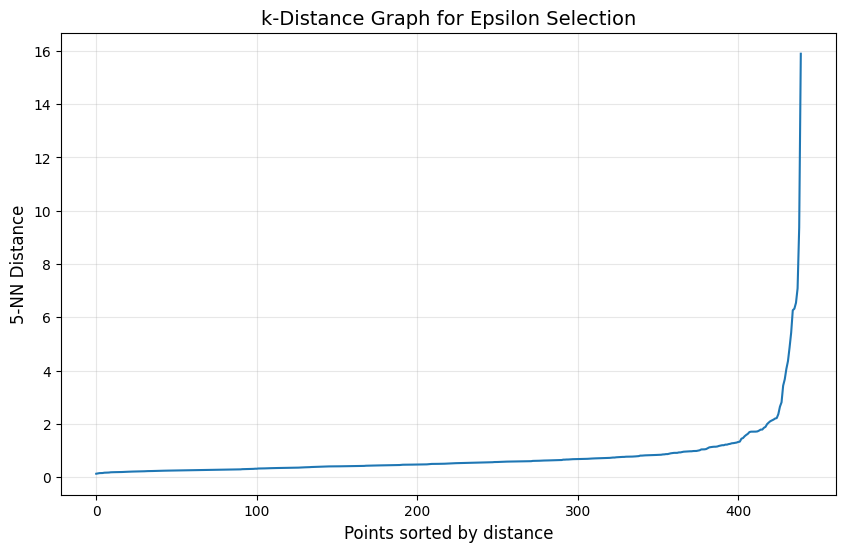

In [21]:
#DBSCAN Clustering

from sklearn.neighbors import NearestNeighbors

# Find optimal eps using k-distance graph
k = 5  # min_samples parameter
nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Sort distances
distances = np.sort(distances[:, k-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance', fontsize=12)
plt.ylabel(f'{k}-NN Distance', fontsize=12)
plt.title('k-Distance Graph for Epsilon Selection', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()


In [22]:
eps = 1.5
print(f"Selected eps value: {eps}")

Selected eps value: 1.5


In [23]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=eps, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add cluster labels to dataframe
df['DBSCAN_Cluster'] = dbscan_labels

# Display cluster statistics
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN Clustering Results:")
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print("\nCluster Sizes:")
print(df['DBSCAN_Cluster'].value_counts().sort_index())

DBSCAN Clustering Results:
Number of clusters: 1
Number of noise points: 27

Cluster Sizes:
DBSCAN_Cluster
-1     27
 0    413
Name: count, dtype: int64


In [24]:
if n_clusters > 1:
    mask = dbscan_labels != -1
    if sum(mask) > 0:
        silhouette_dbscan = silhouette_score(X_scaled[mask], dbscan_labels[mask])
        print(f"\nSilhouette Score (excluding noise): {silhouette_dbscan:.3f}")

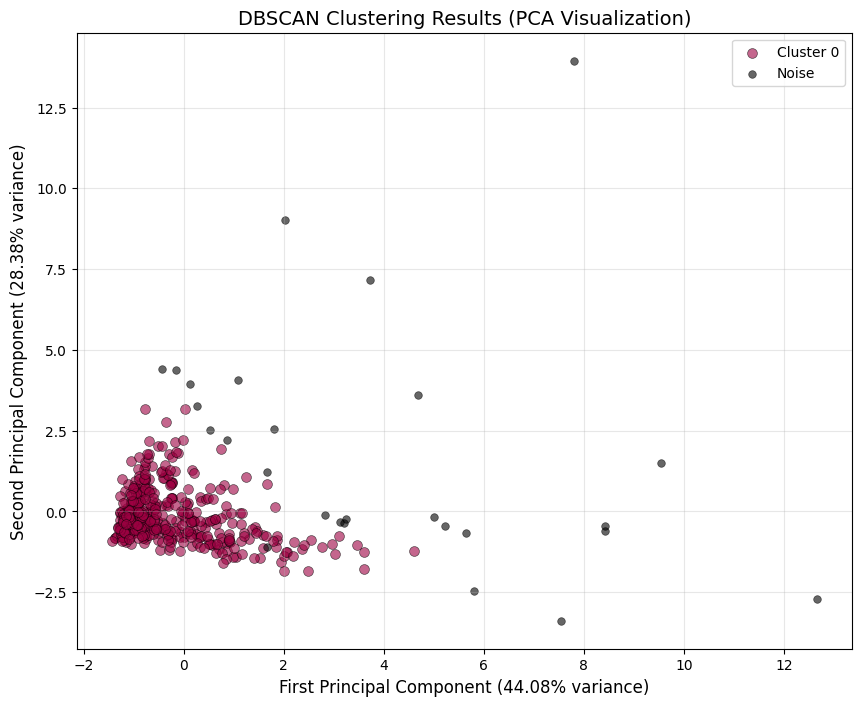

In [25]:
# Visualize DBSCAN clusters
plt.figure(figsize=(10, 8))

# Create custom colormap for DBSCAN (including noise points)
unique_labels = set(dbscan_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black color for noise
        col = 'black'
        marker_size = 30
        label = 'Noise'
    else:
        marker_size = 50
        label = f'Cluster {k}'

    class_member_mask = (dbscan_labels == k)
    xy = X_pca_viz[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], s=marker_size,
               label=label, alpha=0.6, edgecolors='black', linewidth=0.5)

plt.xlabel(f'First Principal Component ({pca_viz.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'Second Principal Component ({pca_viz.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('DBSCAN Clustering Results (PCA Visualization)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [26]:
#PCA for Dimensionality Reduction
pca = PCA()
X_pca = pca.fit_transform(X_scaled)



NameError: name 'cumulative_variance' is not defined

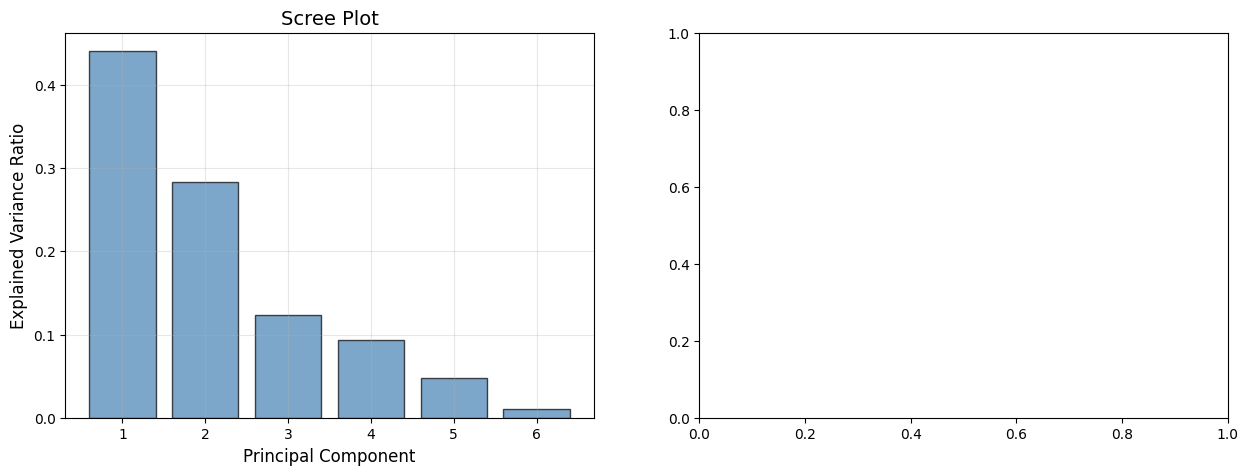

In [27]:
# Plot explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Scree plot
ax1.bar(range(1, len(pca.explained_variance_ratio_) + 1),
        pca.explained_variance_ratio_,
        alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Explained Variance Ratio', fontsize=12)
ax1.set_title('Scree Plot', fontsize=14)
ax1.grid(True, alpha=0.3)

# Cumulative variance plot
ax2.plot(range(1, len(cumulative_variance) + 1),
         cumulative_variance, 'ro-', linewidth=2, markersize=8)
ax2.axhline(y=0.8, color='k', linestyle='--', label='80% Variance')
ax2.axhline(y=0.9, color='g', linestyle='--', label='90% Variance')
ax2.set_xlabel('Number of Components', fontsize=12)
ax2.set_ylabel('Cumulative Explained Variance', fontsize=12)
ax2.set_title('Cumulative Explained Variance', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [28]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)


# Find number of components for 80% and 90% variance
n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1

print(f"Number of components for 80% variance: {n_components_80}")
print(f"Number of components for 90% variance: {n_components_90}")
print(f"\nVariance explained by each component:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var:.3f} ({var*100:.1f}%)")

Number of components for 80% variance: 3
Number of components for 90% variance: 4

Variance explained by each component:
PC1: 0.441 (44.1%)
PC2: 0.284 (28.4%)
PC3: 0.123 (12.3%)
PC4: 0.094 (9.4%)
PC5: 0.048 (4.8%)
PC6: 0.010 (1.0%)


In [32]:

pca_reduced = PCA(n_components=n_components_90, random_state=42)
X_pca_reduced = pca_reduced.fit_transform(X_scaled)

print(f"Original dimensions: {X_scaled.shape[1]}")
print(f"Reduced dimensions: {X_pca_reduced.shape[1]}")
print(f"Variance preserved: {pca_reduced.explained_variance_ratio_.sum():.3f}")

# Create DataFrame with reduced features
pca_features_df = pd.DataFrame(
    X_pca_reduced,
    columns=[f'PC{i+1}' for i in range(n_components_90)]
)

pca_features_df.head()

Original dimensions: 6
Reduced dimensions: 4
Variance preserved: 0.942


,PC1,PC2,PC3,PC4
0,0.193291,-0.305100,0.140878,-0.486432
1,0.434420,-0.328413,-0.319007,-0.178830
2,0.811143,0.815096,-1.523416,-1.254082
3,-0.778648,0.652754,-0.163012,0.380060
4,0.166287,1.271434,-0.066279,-0.826227
